In [84]:
## Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
import copy
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score


## Suppress warnings on console
warnings.filterwarnings("default", category=DeprecationWarning)

In [85]:
#input_file = pd.read_csv('./Final_Files/sample_refined.csv')
input_file = pd.read_csv('./Final_Files/sample_refined_updated.csv')

In [86]:
# Shuffle data frame

input_file = input_file.sample(frac=1)
input_file.head()

,acousticness,analysis_url,danceability,duration_ms,energy,track_id,instrumentalness,key,liveness,loudness,...,track_href,type,uri,valence,artist_name,track_name,popularity,bbhot,artist_popularity,artist_followers
3615,0.18600,https://api.spotify.com/v1/audio-analysis/2VdT...,0.601,206453,0.590,2VdT56BGpdqNHUgOe1j5vc,0.000000,2,0.0942,-5.001,...,https://api.spotify.com/v1/tracks/2VdT56BGpdqN...,audio_features,spotify:track:2VdT56BGpdqNHUgOe1j5vc,0.2740,Post Malone,Rich & Sad,80,1,96,13573663
312,0.33600,https://api.spotify.com/v1/audio-analysis/4qJx...,0.621,231027,0.726,4qJxbwLxEyBbfFqYLJ707S,0.000000,0,0.2070,-5.624,...,https://api.spotify.com/v1/tracks/4qJxbwLxEyBb...,audio_features,spotify:track:4qJxbwLxEyBbfFqYLJ707S,0.7880,JAGMAC,Like Me,53,1,40,4595
2519,0.19900,https://api.spotify.com/v1/audio-analysis/6VZ1...,0.746,187559,0.544,6VZ10jug9GcFvNjd6w8kSI,0.000018,7,0.3150,-6.748,...,https://api.spotify.com/v1/tracks/6VZ10jug9GcF...,audio_features,spotify:track:6VZ10jug9GcFvNjd6w8kSI,0.2600,Russ,Look,56,1,83,2249132
14,0.07340,https://api.spotify.com/v1/audio-analysis/2Y0y...,0.499,298520,0.654,2Y0y4yxzNmKceQ0nBK2Qwj,0.000144,6,0.1040,-6.782,...,https://api.spotify.com/v1/tracks/2Y0y4yxzNmKc...,audio_features,spotify:track:2Y0y4yxzNmKceQ0nBK2Qwj,0.0464,Machine Gun Kelly,27,60,1,78,1434338
171,0.00359,https://api.spotify.com/v1/audio-analysis/4ksu...,0.758,223240,0.490,4ksuI04WMvUnJbHQjgs3L5,0.000007,11,0.2920,-9.877,...,https://api.spotify.com/v1/tracks/4ksuI04WMvUn...,audio_features,spotify:track:4ksuI04WMvUnJbHQjgs3L5,0.3350,Drake,Talk Up (feat. Jay-Z),69,0,97,36432738


Text(0, 0.5, 'popularity')

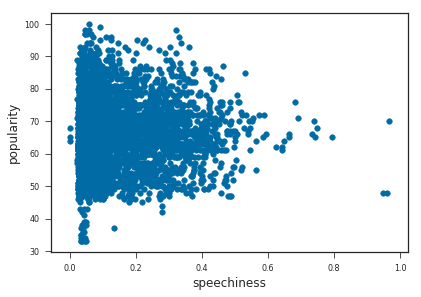

In [87]:
plt.scatter(input_file['speechiness'],input_file['popularity'])
plt.xlabel('speechiness')
plt.ylabel('popularity')


In [88]:
## Dropping fields (strings/objects)

'''
drop_list = ['analysis_url','track_id', 'track_href', 'type', 'uri', 
             'artist_name', 'track_name']
'''
#drop_list = ['analysis_url','track_id', 'track_href', 'type', 'uri', 
#             'artist_name', 'track_name', 'key', 'mode', 'time_signature', 'popularity']

drop_list = ['analysis_url','track_id', 'track_href', 'type', 'uri', 
             'artist_name', 'track_name', 'time_signature', 'popularity']

             
train = input_file.drop(drop_list, axis = 1)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 3615 to 2098
Data columns (total 15 columns):
acousticness         5000 non-null float64
danceability         5000 non-null float64
duration_ms          5000 non-null int64
energy               5000 non-null float64
instrumentalness     5000 non-null float64
key                  5000 non-null int64
liveness             5000 non-null float64
loudness             5000 non-null float64
mode                 5000 non-null int64
speechiness          5000 non-null float64
tempo                5000 non-null float64
valence              5000 non-null float64
bbhot                5000 non-null int64
artist_popularity    5000 non-null int64
artist_followers     5000 non-null int64
dtypes: float64(9), int64(6)
memory usage: 625.0 KB


In [89]:
input_file.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,bbhot,artist_popularity,artist_followers
count,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.000000,5.000000e+03
mean,0.266222,0.650610,2.038833e+05,0.593527,0.065873,5.275800,0.171321,-7.430599,0.58780,0.124946,120.346522,3.949000,0.436074,65.95540,0.50000,73.737000,3.206522e+06
std,0.284436,0.161101,5.151627e+04,0.203449,0.216466,3.618612,0.126541,4.247411,0.49228,0.118186,30.120835,0.338263,0.219097,9.85631,0.50005,14.919972,5.972459e+06
min,0.000003,0.000000,3.524000e+04,0.000900,0.000000,0.000000,0.019600,-41.537000,0.00000,0.000000,0.000000,0.000000,0.000000,33.00000,0.00000,0.000000,0.000000e+00
25%,0.038775,0.552000,1.771382e+05,0.474000,0.000000,2.000000,0.098575,-8.463250,0.00000,0.041400,95.980000,4.000000,0.268000,60.00000,0.00000,65.000000,1.389320e+05
50%,0.153000,0.667000,2.017070e+05,0.609000,0.000000,5.000000,0.120000,-6.443000,1.00000,0.069400,119.975500,4.000000,0.422000,66.00000,0.50000,75.000000,7.818130e+05
75%,0.415000,0.767000,2.281582e+05,0.741250,0.000182,8.000000,0.199000,-5.010500,1.00000,0.175250,141.987000,4.000000,0.592000,72.00000,1.00000,85.000000,3.138132e+06
max,0.996000,0.972000,1.355938e+06,0.998000,1.000000,11.000000,0.979000,0.605000,1.00000,0.966000,220.099000,5.000000,0.990000,100.00000,1.00000,100.000000,4.368682e+07


In [90]:
## Making a copy of dataframe target variable and assigning it to Y
Y = copy.deepcopy(train.bbhot)
Y.shape

(5000,)

In [91]:
## Dropping the target attribute and making new dataframe

train_1 = train.drop("bbhot", axis=1)
train_1.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,artist_popularity,artist_followers
3615,0.18600,0.601,206453,0.590,0.000000,2,0.0942,-5.001,1,0.0569,151.952,0.2740,96,13573663
312,0.33600,0.621,231027,0.726,0.000000,0,0.2070,-5.624,1,0.2090,104.888,0.7880,40,4595
2519,0.19900,0.746,187559,0.544,0.000018,7,0.3150,-6.748,0,0.0424,127.990,0.2600,83,2249132
14,0.07340,0.499,298520,0.654,0.000144,6,0.1040,-6.782,1,0.1100,169.839,0.0464,78,1434338
171,0.00359,0.758,223240,0.490,0.000007,11,0.2920,-9.877,1,0.1390,140.116,0.3350,97,36432738


In [92]:
#pd.set_option('display.precision', 2)
train_1.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,artist_popularity,artist_followers
count,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,0.266222,0.650610,2.038833e+05,0.593527,0.065873,5.275800,0.171321,-7.430599,0.58780,0.124946,120.346522,0.436074,73.737000,3.206522e+06
std,0.284436,0.161101,5.151627e+04,0.203449,0.216466,3.618612,0.126541,4.247411,0.49228,0.118186,30.120835,0.219097,14.919972,5.972459e+06
min,0.000003,0.000000,3.524000e+04,0.000900,0.000000,0.000000,0.019600,-41.537000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.038775,0.552000,1.771382e+05,0.474000,0.000000,2.000000,0.098575,-8.463250,0.00000,0.041400,95.980000,0.268000,65.000000,1.389320e+05
50%,0.153000,0.667000,2.017070e+05,0.609000,0.000000,5.000000,0.120000,-6.443000,1.00000,0.069400,119.975500,0.422000,75.000000,7.818130e+05
75%,0.415000,0.767000,2.281582e+05,0.741250,0.000182,8.000000,0.199000,-5.010500,1.00000,0.175250,141.987000,0.592000,85.000000,3.138132e+06
max,0.996000,0.972000,1.355938e+06,0.998000,1.000000,11.000000,0.979000,0.605000,1.00000,0.966000,220.099000,0.990000,100.000000,4.368682e+07


In [93]:
## Creating standard scaler object

warnings.filterwarnings("ignore")

#scaler = StandardScaler()

scaler = MinMaxScaler()

## Fit scaler to features

scaler.fit(train_1)

# Transform features to scaled version

scaled_features = scaler.transform(train_1)

#Convert the scaled features to a dataframe and check the head of this dataframe to make sure the scaling worked.

#df_feat = pd.DataFrame(scaled_features,columns=train.columns[:-1])

df_feat = pd.DataFrame(scaled_features,columns=train_1.columns)
df_feat.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,artist_popularity,artist_followers
0,0.186744,0.618313,0.129638,0.590813,0.000000,0.181818,0.077757,0.866974,1.0,0.058903,0.690380,0.276768,0.96,0.310704
1,0.337347,0.638889,0.148245,0.727209,0.000000,0.000000,0.195330,0.852190,1.0,0.216356,0.476549,0.795960,0.40,0.000105
2,0.199797,0.767490,0.115332,0.544680,0.000018,0.636364,0.307901,0.825518,0.0,0.043892,0.581511,0.262626,0.83,0.051483
3,0.073692,0.513374,0.199349,0.654999,0.000144,0.545455,0.087972,0.824712,1.0,0.113872,0.771648,0.046869,0.78,0.032832
4,0.003601,0.779835,0.142349,0.490523,0.000007,1.000000,0.283927,0.751270,1.0,0.143892,0.636604,0.338384,0.97,0.833953


In [94]:
df_feat.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,artist_popularity,artist_followers
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,0.267289,0.669352,0.127693,0.594351,0.065873,0.479618,0.158142,0.809321,0.58780,0.129344,0.546784,0.440478,0.73737,0.073398
std,0.285579,0.165742,0.039007,0.204041,0.216466,0.328965,0.131896,0.100788,0.49228,0.122346,0.136851,0.221310,0.14920,0.136711
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.038928,0.567901,0.107442,0.474476,0.000000,0.181818,0.082317,0.784817,0.00000,0.042857,0.436076,0.270707,0.65000,0.003180
50%,0.153612,0.686214,0.126045,0.609869,0.000000,0.454545,0.104649,0.832756,1.00000,0.071843,0.545098,0.426263,0.75000,0.017896
75%,0.416665,0.789095,0.146073,0.742503,0.000182,0.727273,0.186992,0.866748,1.00000,0.181418,0.645105,0.597980,0.85000,0.071832
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000


In [95]:
#Function to evaluate my model with Cross validation

from sklearn.model_selection import cross_val_score

def testingModel(model, X_train, Y_train):
    scores = cross_val_score(model, X_train, Y_train, cv=10, scoring = "roc_auc")
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    return scores.mean()

In [96]:
## Training a decision tree model without cross validation

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix

X = df_feat
y = Y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

warnings.filterwarnings("ignore")


dtree = DecisionTreeClassifier()

dtree.fit(X_train,y_train)

predictions = dtree.predict(X_test)

accuracy = dtree.score(X_test, y_test)
print("Prediction Accuracy Without Cross Validation: %.2f%%" % (accuracy * 100.0))

print("Confusion Matrix: ")
print(confusion_matrix(y_test,predictions))

print("Classification Report: ")
print(classification_report(y_test,predictions))

Prediction Accuracy Without Cross Validation: 57.73%
Confusion Matrix: 
[[422 313]
 [321 444]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.57      0.57      0.57       735
           1       0.59      0.58      0.58       765

   micro avg       0.58      0.58      0.58      1500
   macro avg       0.58      0.58      0.58      1500
weighted avg       0.58      0.58      0.58      1500



In [97]:
## Implementing decision tree with cross validation

dt = DecisionTreeClassifier()
dt.fit(df_feat, Y)
acc_decision_tree = testingModel(dt, df_feat, Y)

print("Prediction Accuracy With 10-Fold Cross Validation(Mean Value): %.2f%%" % (acc_decision_tree * 100.0))

Scores: [0.568 0.558 0.568 0.566 0.61  0.59  0.572 0.588 0.556 0.6  ]
Mean: 0.5776000000000001
Standard Deviation: 0.01736202753136856
Prediction Accuracy With 10-Fold Cross Validation(Mean Value): 57.76%


In [98]:
print("Hyperparameters: ",dt.get_params)

Hyperparameters:  <bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>


In [99]:
## Training a random forest model without cross validation

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=600)

#X_train = pca.fit_transform(X_train)  
#X_test = pca.transform(X_test)

rfc.fit(X_train,y_train)

predictions = rfc.predict(X_test)

accuracy = rfc.score(X_test, y_test)
print("Prediction Accuracy Without Cross Validation: %.2f%%" % (accuracy * 100.0))

print("Confusion Matrix: ")
print(confusion_matrix(y_test,predictions))

print("Classification Report: ")
print(classification_report(y_test,predictions))

#print("Number of trees used in the forest (n_estimators): ",rfc.)


Prediction Accuracy Without Cross Validation: 61.87%
Confusion Matrix: 
[[455 280]
 [292 473]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.61      0.62      0.61       735
           1       0.63      0.62      0.62       765

   micro avg       0.62      0.62      0.62      1500
   macro avg       0.62      0.62      0.62      1500
weighted avg       0.62      0.62      0.62      1500



In [100]:
## Implementing Random forest with cross validation

rf = RandomForestClassifier(n_estimators=600, oob_score = True)
rf.fit(df_feat, Y)
acc_random_forest = testingModel(rf, df_feat, Y)
print("Prediction Accuracy With 10-Fold Cross Validation(Mean Value): %.2f%%" % (acc_random_forest * 100.0))

Scores: [0.67072  0.711848 0.670208 0.719024 0.69656  0.695984 0.687864 0.676592
 0.648832 0.727544]
Mean: 0.6905176000000001
Standard Deviation: 0.023341005167729984
Prediction Accuracy With 10-Fold Cross Validation(Mean Value): 69.05%


In [101]:
print("Hyperparameters: ",rf.get_params)

Hyperparameters:  <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)>


In [65]:
## Implementing Gradient Boosting without CV

from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(df_feat, Y, test_size=0.30, random_state=7)
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# make predictions for test data

y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 63.60%


In [66]:
## Implementing Gradient Boosting with CV

gb = GradientBoostingClassifier(n_estimators=600)
gb.fit(df_feat, Y)
acc_gb_forest = testingModel(gb, df_feat, Y)
print("Prediction Accuracy With 10-Fold Cross Validation(Mean Value): %.2f%%" % (acc_gb_forest * 100.0))

Scores: [0.740592 0.669584 0.698    0.70952  0.689264 0.666336 0.688288 0.728048
 0.699008 0.727584]
Mean: 0.7016224
Standard Deviation: 0.02361228718781813
Prediction Accuracy With 10-Fold Cross Validation(Mean Value): 70.16%


In [102]:
## Implementing XG Boost without cross validation
## Installed pip install xgboost==0.80. Newer version was causing kernel to crash

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(df_feat, Y, test_size=0.30, random_state=7)
#model = XGBClassifier()

model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model.fit(X_train, y_train)

# make predictions for test data

y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print("Prediction Accuracy Without Cross Validation: %.2f%%" % (accuracy * 100.0))

print("Confusion Matrix: ")
print(confusion_matrix(y_test,predictions))

print("Classification Report: ")
print(classification_report(y_test,predictions))



Prediction Accuracy Without Cross Validation: 61.73%
Confusion Matrix: 
[[363 357]
 [384 396]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.49      0.50      0.49       720
           1       0.53      0.51      0.52       780

   micro avg       0.51      0.51      0.51      1500
   macro avg       0.51      0.51      0.51      1500
weighted avg       0.51      0.51      0.51      1500



In [103]:
## Implementing XG Boost after hyperparameter tuning and cross validation

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=600,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


xgb1.fit(df_feat, Y)
    
acc_xgb = testingModel(xgb1, df_feat, Y)

print("Prediction Accuracy With 10-Fold Cross Validation(Mean Value): %.2f%%" % (acc_xgb * 100.0))

Scores: [0.67456  0.702832 0.672032 0.715392 0.687888 0.69464  0.676624 0.667264
 0.666592 0.711472]
Mean: 0.6869295999999998
Standard Deviation: 0.0173412727745111
Prediction Accuracy With 10-Fold Cross Validation(Mean Value): 68.69%


In [104]:
print("Hyperparameters: ",xgb1.get_params)

Hyperparameters:  <bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)>


In [ ]:
## Implementing grid search for XG Boost
'''
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=500, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, n_threads=-1), 
param_grid = params, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_feat,Y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

'''

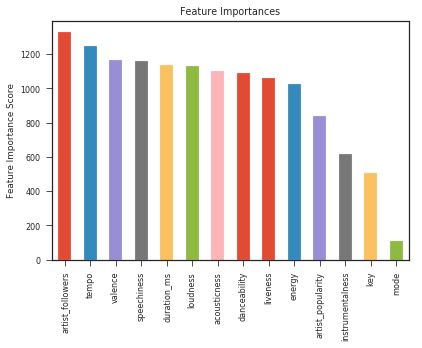

In [71]:
feat_imp = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)
#feat_imp = pd.Series(rf.feature_importances_.sort_values(ascending=False))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

In [72]:
#from sklearn.ensemble import ExtraTreesClassifier

#etc_model = ExtraTreesClassifier()
#etc_model.fit(X_train, y_train)

etc_df = pd.DataFrame(xgb1.feature_importances_, index = X_train.columns.values, columns =['importance']).sort_values('importance',ascending=[False])

etc_df



,importance
artist_followers,0.098366
tempo,0.092227
valence,0.086162
speechiness,0.086014
duration_ms,0.084017
loudness,0.083722
acousticness,0.081577
danceability,0.080763
liveness,0.078323
energy,0.075660


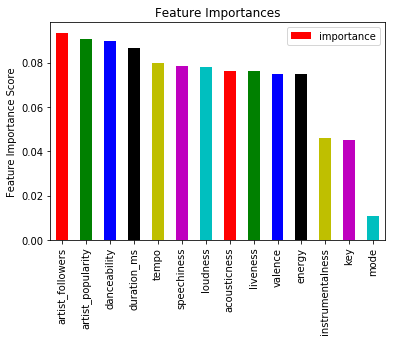

In [21]:
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())

#feat_imp = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)
#etc_df.plot(kind='bar', title='Feature Importances',color=(colors_list[8],colors_list[1],colors_list[3]))
etc_df.plot(kind='bar', title='Feature Importances',color='rgbkymc')
plt.ylabel('Feature Importance Score')
plt.show()

In [22]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
acousticness         5000 non-null float64
danceability         5000 non-null float64
duration_ms          5000 non-null float64
energy               5000 non-null float64
instrumentalness     5000 non-null float64
key                  5000 non-null float64
liveness             5000 non-null float64
loudness             5000 non-null float64
mode                 5000 non-null float64
speechiness          5000 non-null float64
tempo                5000 non-null float64
valence              5000 non-null float64
artist_popularity    5000 non-null float64
dtypes: float64(13)
memory usage: 507.9 KB


In [73]:
## Implementing PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=14)
pca.fit(df_feat)

PCA(copy=True, iterated_power='auto', n_components=14, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [74]:
## Calculating eigen values

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var

# The first feature explains 36.5% of the variance within our data set while the first two 
# explain 56.6% and so on. If we employ all features we capture 100% of the variance within
# the dataset, thus we gain some by implementing an additional feature. No any single 
# feature is outstanding.

array([35.5, 55.1, 69.8, 76.6, 82.1, 86. , 89.6, 92.3, 94.7, 96.5, 98.1,
       99.3, 99.6, 99.8])

In [75]:
pca.explained_variance_

array([0.24878313, 0.13751506, 0.1029658 , 0.04786284, 0.03852738,
       0.02752094, 0.02531318, 0.01877597, 0.01692655, 0.01285232,
       0.01137173, 0.00862476, 0.00236713, 0.00136848])

In [76]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')

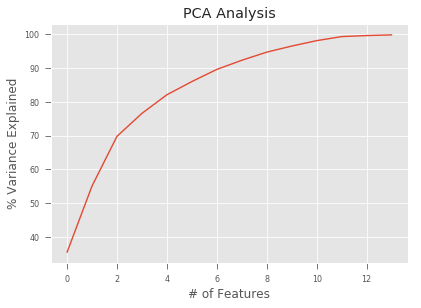

In [78]:
# Sort and select
# Based on the plot below it is clear that we should keep all the 23 features.

#plt.style.context('tableau-colorblind10')
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.use('seaborn-ticks')
plt.plot(var)

Text(0.5, 1.0, 'Correlation Between Different Features')

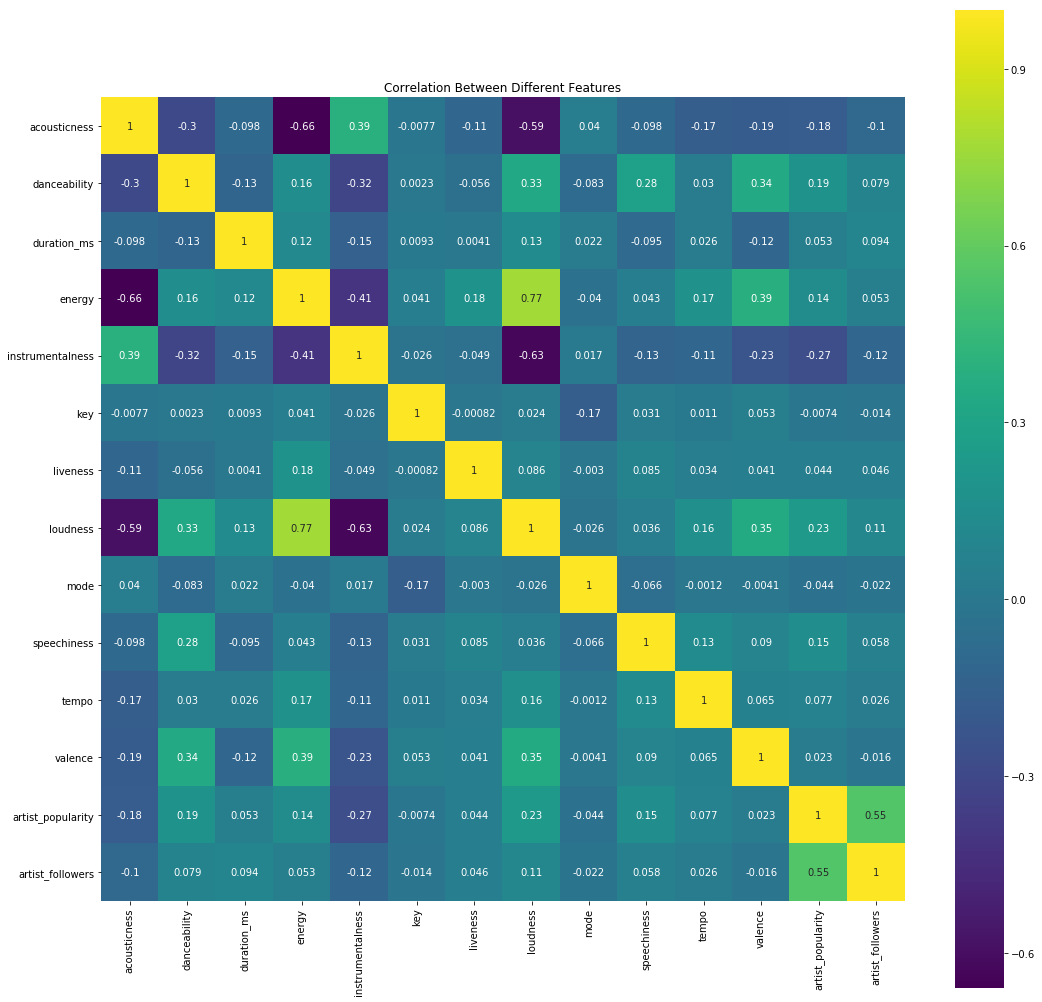

In [29]:
# Correlation

correlation = df_feat.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Correlation Between Different Features')

Text(0.5, 0.98, 'Strongest Positive Correlation')

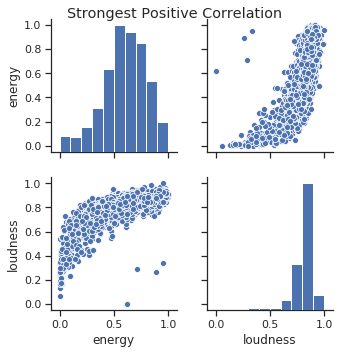

In [33]:
## Strongest positive correlation

sns.set(style="ticks", color_codes=True)

g = sns.pairplot(df_feat, vars=["energy", "loudness"])

#sns.pairplot(df_feat, vars=["energy", "loudness"], diag_kind="kde")

g.fig.suptitle("Strongest Positive Correlation")


Text(0.5, 0.98, 'Strongest Negative Correlation')

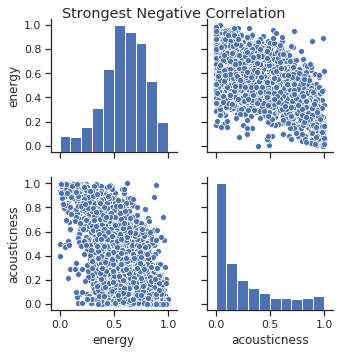

In [34]:
## Strongest Negative Correlation

sns.set(style="ticks", color_codes="Red")

g = sns.pairplot(df_feat, vars=["energy", "acousticness"])

#sns.pairplot(df_feat, vars=["energy", "acousticness"], diag_kind="kde")

g.fig.suptitle("Strongest Negative Correlation")



Text(0.5, 0.98, 'Strongest Negative Correlation')

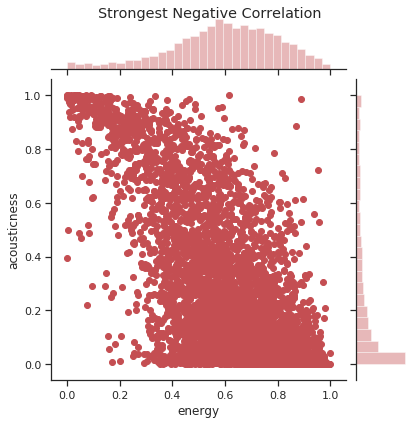

In [35]:
#g = sns.jointplot(df_feat['energy'],df_feat['loudness'], color="g")

#g.fig.suptitle("Strongest Positive Correlation")

g = sns.jointplot(df_feat['energy'],df_feat['acousticness'], color="r")

g.fig.suptitle("Strongest Negative Correlation")



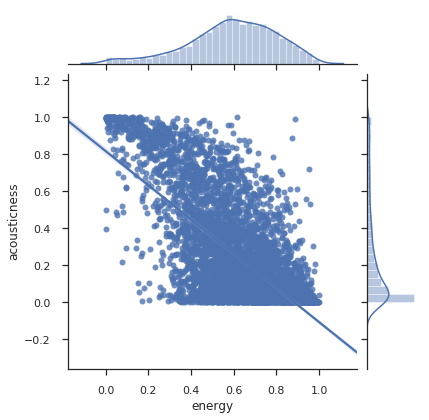

In [262]:
g = sns.jointplot("energy", "acousticness", data=df_feat, kind="reg")

In [36]:
song_df = pd.read_csv('./Final_Files/single_song.csv')

song_df.head()

,acousticness,analysis_url,danceability,duration_ms,energy,track_id,instrumentalness,key,liveness,loudness,...,tempo,time_signature,track_href,type,uri,valence,artist_name,track_name,popularity,artist_popularity
0,0.0501,https://api.spotify.com/v1/audio-analysis/0rTV...,0.9,197487,0.4,0rTV5WefWd1J3OwIheTzxM,0,0,0.0876,-8.443,...,136.001,4,https://api.spotify.com/v1/tracks/0rTV5WefWd1J...,audio_features,spotify:track:0rTV5WefWd1J3OwIheTzxM,0.338,Khalid,Talk,95,98


In [171]:
drop_list = ['analysis_url','track_id', 'track_href', 'type', 'uri', 
             'artist_name', 'track_name','time_signature','popularity']

song_1 = song_df.drop(drop_list, axis = 1)

song_1.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,artist_popularity
0,0.05,0.9,197487,0.4,0,0,0.09,-8.44,1,0.12,136.0,0.34,98


In [172]:
#new_scaler = MinMaxScaler()

## Fit scaler to features

#new_scaler.fit(song_1)

# Transform features to scaled version

#new_scaled_features = new_scaler.transform(song_1)

#Convert the scaled features to a dataframe and check the head of this dataframe to make sure the scaling worked.

#df_feat = pd.DataFrame(scaled_features,columns=train.columns[:-1])

#song_1_new = pd.DataFrame(new_scaled_features,columns=song_1.columns)
#song_1_new.head()

In [173]:
#song_tran = song_1.transpose()

#rf.predict_proba(song_1)

#prediction_proba = xgb1.predict_proba(song_1)

#rf.predict(song_1)

## Prediction using Random Forest Model

rf.predict_proba(song_1)

array([[0.42666667, 0.57333333]])

In [160]:
print(prediction_proba)

[[0.63988805 0.36011195]]


In [ ]:
correlations = train.corr()
sns.heatmap(correlations)
plt.show()

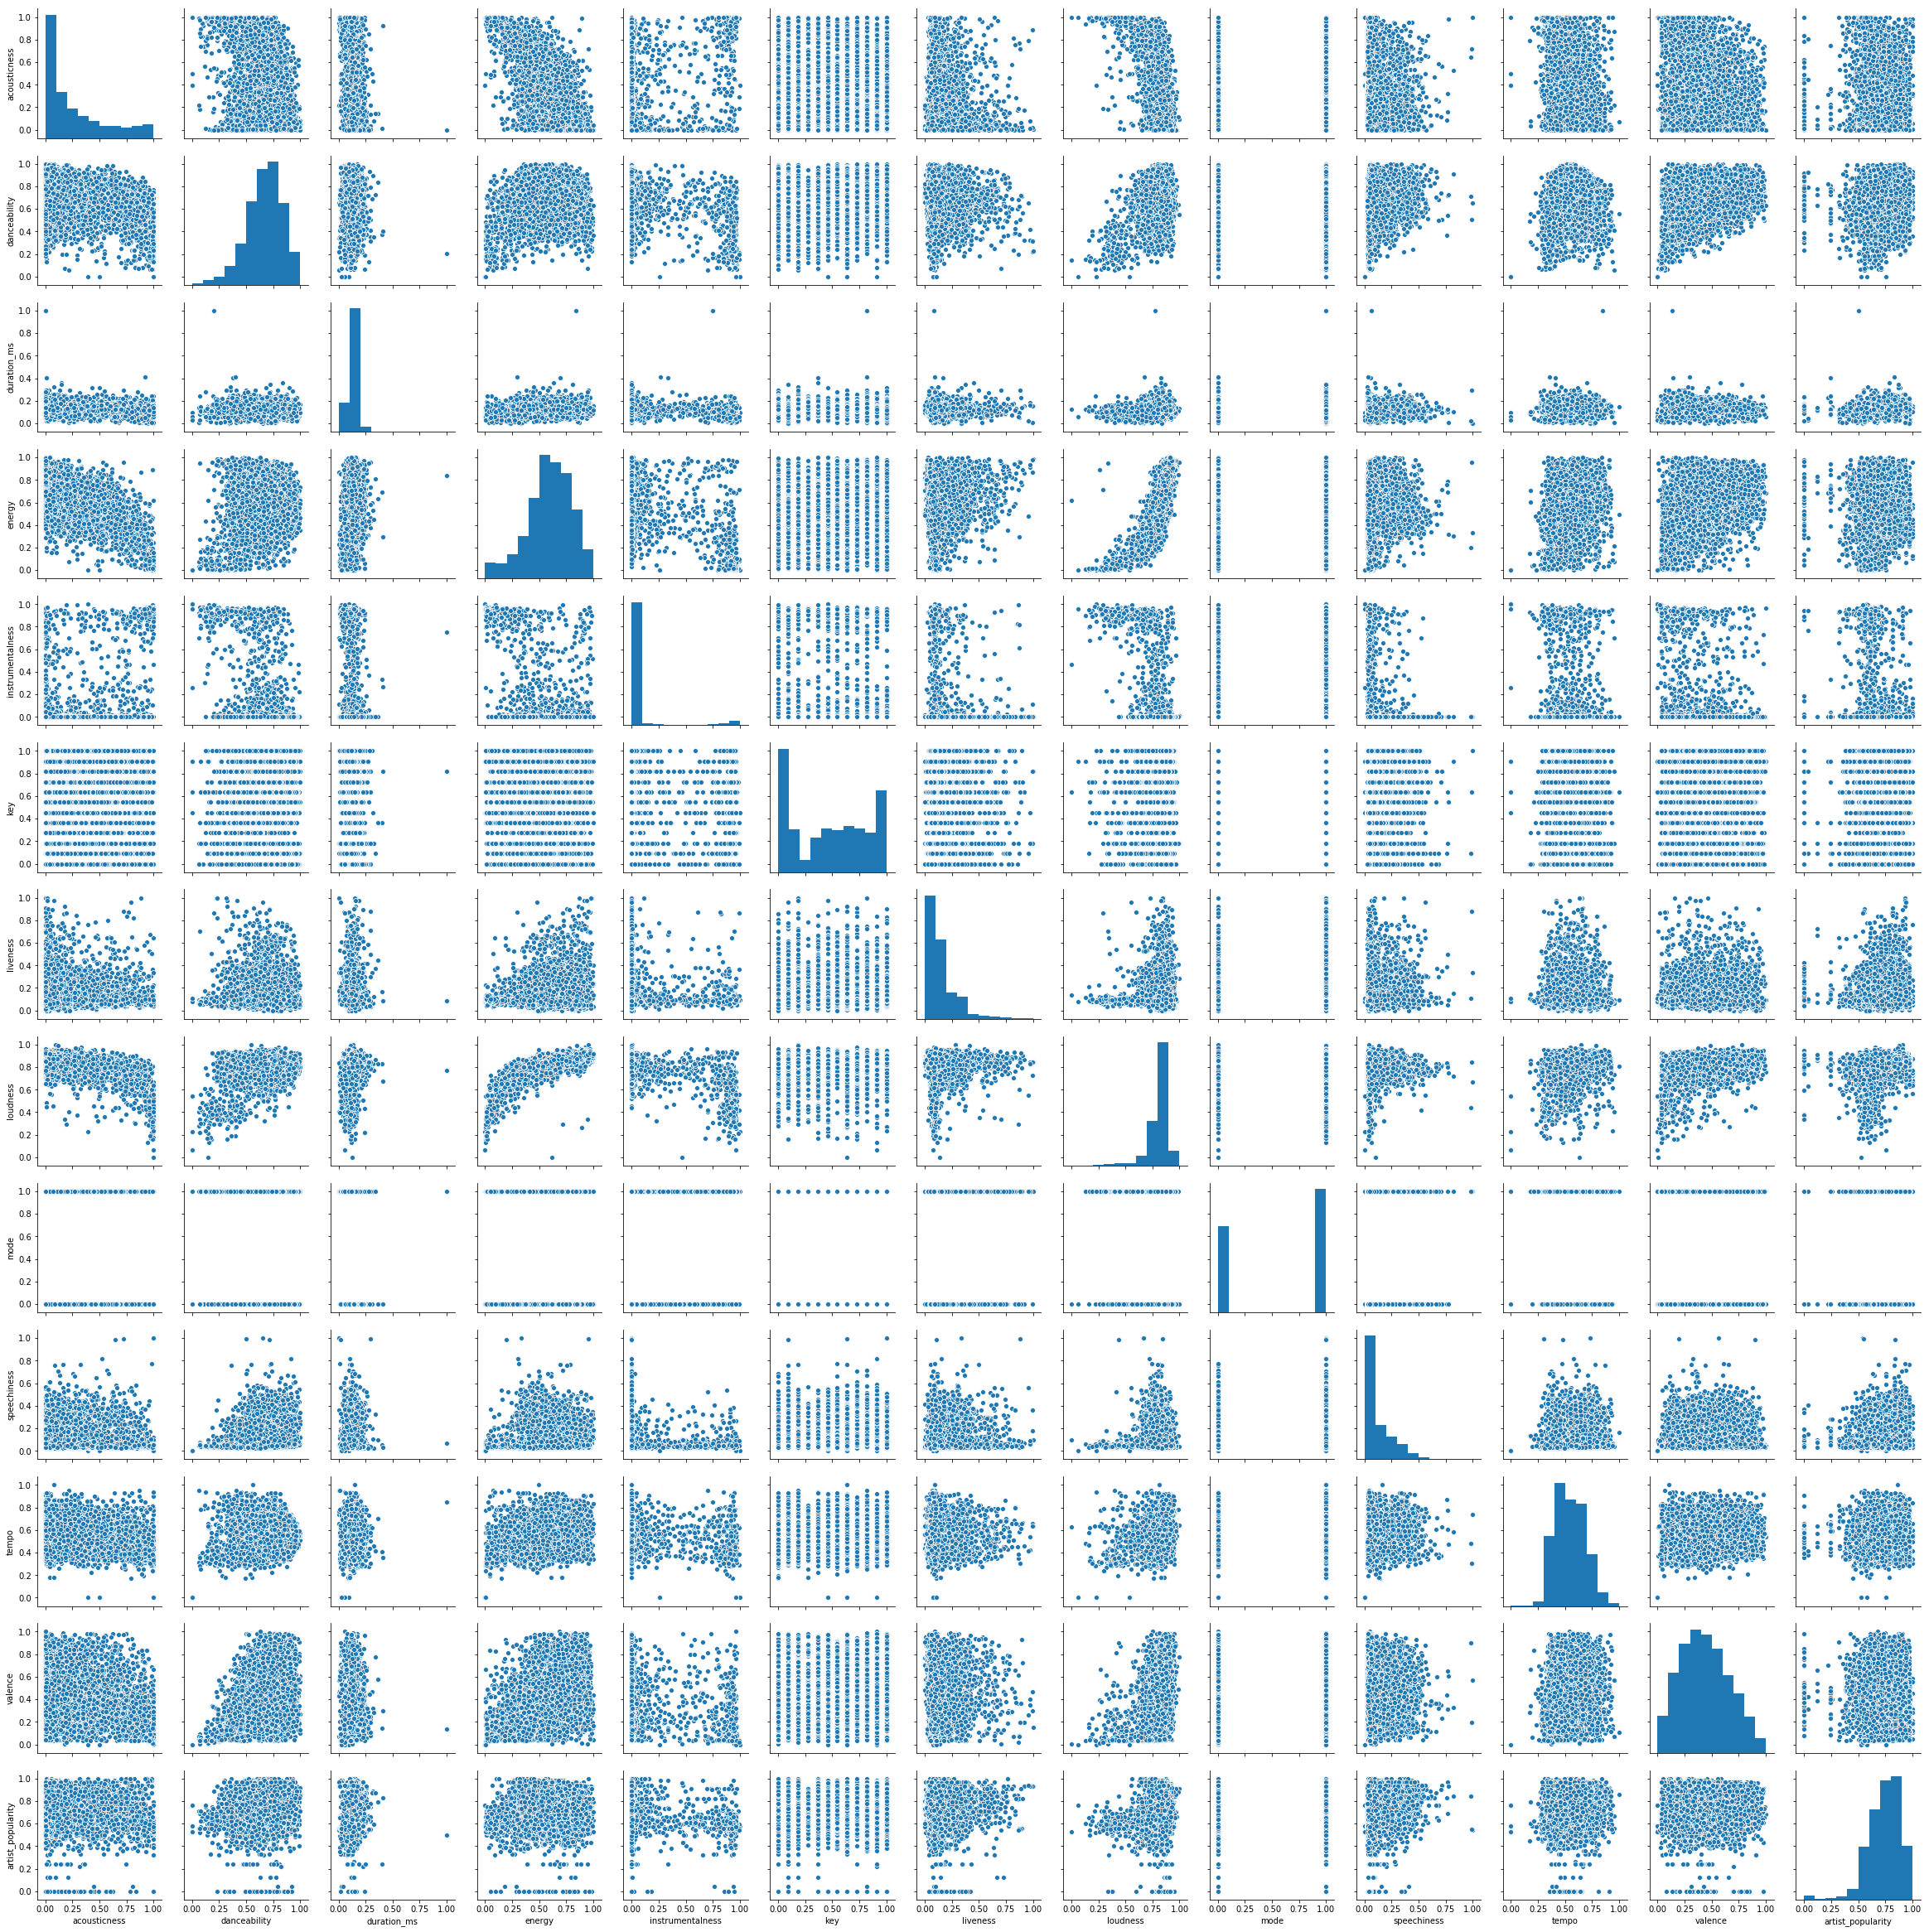

In [29]:
sns.pairplot(df_feat)

In [ ]:
sns.jointplot(x='loudness',y='energy',data=train_1,color='purple')

In [61]:
## Selecting best features

#from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    
    all_X = df_feat
    all_Y = Y
    
    warnings.filterwarnings("ignore")
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_Y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best Columns 
------------
['acousticness', 'danceability', 'duration_ms', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'artist_popularity']



In [79]:
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(df_feat, Y, test_size=0.30, random_state=7)
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)

# make predictions for test data

y_pred = ada_model.predict(X_test)
accuracy = ada_model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.07%


In [23]:
from sklearn.ensemble import ExtraTreesClassifier

etc_model = ExtraTreesClassifier()
etc_model.fit(X_train, y_train)
etc_df = pd.DataFrame(rfc.feature_importances_, index = X_train.columns.values, columns =['importance']).sort_values('importance',ascending=[False])

etc_df



,importance
artist_popularity,0.10
danceability,0.10
duration_ms,0.09
tempo,0.09
speechiness,0.09
loudness,0.09
valence,0.09
acousticness,0.08
liveness,0.08
energy,0.08


In [139]:
hits_csv = pd.read_csv("./Final_Files/sample_refined_hits.csv")

Text(0.5, 1.0, 'Number Of Hits based on a Key')

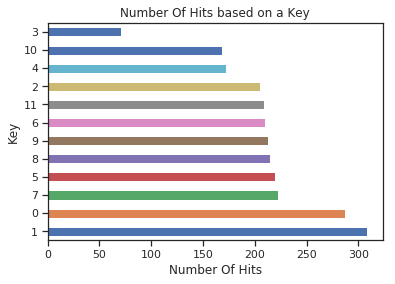

In [110]:
#hits_csv['duration_ms'].value_counts().hist()

fig, ax = plt.subplots()
#hits_csv['duration_ms'].value_counts().plot(ax=ax, kind='bar')
                
hits_csv['key'].value_counts().plot(ax=ax, kind='barh')
plt.xlabel("Number Of Hits")
plt.ylabel("Key")
plt.title("Number Of Hits based on a Key")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a408d57f0>]],
      dtype=object)

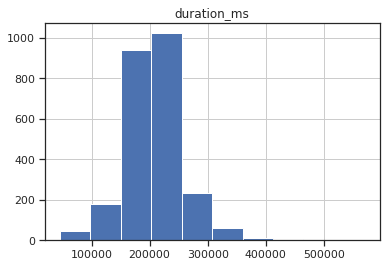

In [137]:
from matplotlib.ticker import StrMethodFormatter

#hits_csv['duration_ms'].value_counts()
hits_csv.hist(column='duration_ms',bins=10)

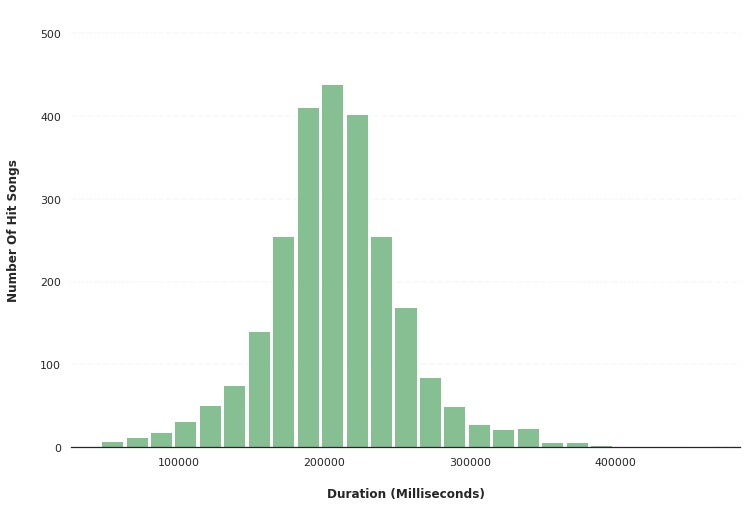

In [140]:
ax = hits_csv.hist(column='duration_ms', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Duration (Milliseconds)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Number Of Hit Songs", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

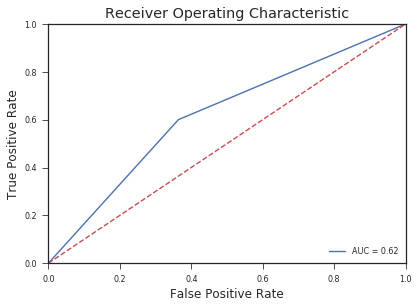

In [106]:
## Plot ROC Curve

y_pred = model.predict(X_test)

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
#probs = xgb1.predict_proba(X_test)
probs = xgb1.predict_proba(X_test)
preds = probs[:,1]
#fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.style.use('tableau-colorblind10')
plt.show()